In this notebook, we determine what fraction of events of a particular reaction have muon that enters the detector,
making the simplifying assumption that there is a uniform distribution of the particles' kinematics in the available phase space.
The reaction is $e p \rightarrow e'D_0\Lambda_c^+$ followed by $\Lambda_c^+\rightarrow\Lambda^0\bar\nu_\mu\mu^+$.  In principle,
the code used in this simplified event generator could be used for other reactions as well.  

The generation of three-particle events follows Phys. Rev. D 86, 114023 (2012) https://arxiv.org/abs/1210.7939 .  

In [1]:
import ROOT, numpy as np, random, pandas as pd, matplotlib

import matplotlib.pylab as plt
plt.rcParams["figure.figsize"] = [7.00, 5.00]
#presets for plot style
#from scipy.constants import golden
rc = plt.rc
rc('text', usetex=False)
import matplotlib as mpl
rc('font', family='serif')
rc('text', usetex=False)
rc('font', size=16)
rc('xtick', labelsize=16)
rc('ytick', labelsize=16)
rc('axes', labelsize=16)
rc('legend', fontsize=16)

import matplotlib.patches as patches

plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

pdg = ROOT.TDatabasePDG()

Welcome to JupyROOT 6.28/04


In [2]:
rand = random.Random()

In [3]:
class oneToTwoGenerator():
    def __init__(self, m0, m1, m2):
        self.m1 = m1
        self.m2 = m2
        self.m0 = m0
        self.p = np.sqrt(m1**4+m2**4+m0**4-2*m1**2*m0**2-2*m1**2*m2**2-2*m0**2*m2**2)/(2*m0)
        self.E1 = np.hypot(m1, self.p) 
        self.E2 = np.hypot(m2, self.p)
    
    def next(self, P0):
        phi=rand.uniform(-np.pi, np.pi)
        cosTheta=rand.uniform(-1,1)
        sinTheta=np.sqrt(1-cosTheta**2)
        
        p = self.p
        P1 = ROOT.TLorentzVector(p*np.cos(phi)*sinTheta, p*np.sin(phi)*sinTheta, p*cosTheta, self.E1)
        P2 = ROOT.TLorentzVector(-p*np.cos(phi)*sinTheta, -p*np.sin(phi)*sinTheta, -p*cosTheta, self.E2)
        beta = P0.BoostVector()
        P1.Boost(beta)
        P2.Boost(beta)
        #print((P0-P1-P2).M())
        #print((P0-P1-P2).E())
        return P1,P2

 Use the formulas found here to get the 3-particle phase space:  Phys. Rev. D 86, 114023 (2012) https://arxiv.org/abs/1210.7939 

In [4]:
class oneToThreeGenerator():
    def __init__(self, m0, m1, m2, m3):
        self.m0 = m0
        self.x1 = (m1/self.m0)**2
        self.x2 = (m2/self.m0)**2
        self.x3 = (m3/self.m0)**2
        
        self.s13_min = (np.sqrt(self.x1)+np.sqrt(self.x3))**2
        self.s13_max =(1-np.sqrt(self.x2))**2
        print("s13 range:", self.s13_min, self.s13_max)
        self.s13s =np.linspace(self.s13_min,self.s13_max, 1024+2)[1:-1]
        self.pdf = np.sqrt(((1+self.x2-self.s13s)**2-4*self.x2)*((self.x1+self.x3-self.s13s)**2-4*self.x1*self.x3))/self.s13s
        self.pdf /= np.sum(self.pdf)
        self.cdf = [self.pdf[0]]
        for i in range(1,len(self.pdf)):
            self.cdf.append(self.cdf[-1]+self.pdf[i])
        
    def next(self, P0,search="binary"):
        
        #these are for particle 2:
        phi=rand.uniform(-np.pi, np.pi)
        cosTheta=rand.uniform(-1,1)
        sinTheta=np.sqrt(1-cosTheta**2)

        #pdf of s13 is sqrt(((1+x2-s12)^2-4x^2)((x1+x3-s13)^2-4*x1*x3))/s13

        u = rand.uniform(0, 1)
        psum = 0
        s13= (self.s13_min+self.s13_max)/2
        if search == "linear":
            found=False
            for i in range(len(self.cdf)):
                if(self.cdf[i]>u):
                    s13=self.s13s[i]
                    found = True
                    break
            if not found:
                raise Exception("s13 not found in table")
        #perform binary search
        if search == "binary":
            i=512
            di=256
            while di >=1:
                if (u> self.cdf[i]):
                    i+=di
                else :
                    i -=di
                di=di//2
            s13=self.s13s[i]


        p2 = np.sqrt(s13**2 + self.x2**2+1 - 2*s13 - 2*s13*self.x2 - 2*self.x2)/2
        P2 = ROOT.TLorentzVector(p2*np.cos(phi)*sinTheta, p2*np.sin(phi)*sinTheta, p2*cosTheta, np.sqrt(self.x2+p2**2))


        p = np.sqrt(s13**2 + self.x3**2 + self.x1**2 - 2*self.x1*self.x3 - 2*s13*self.x3 - 2*s13*self.x1)/(2*np.sqrt(s13))

        #these are for particles 1, 3
        phi=rand.uniform(-np.pi, np.pi)
        cosTheta=rand.uniform(-1,1)
        sinTheta=np.sqrt(1-cosTheta**2)

        P1 = ROOT.TLorentzVector(p*np.cos(phi)*sinTheta, p*np.sin(phi)*sinTheta, p*cosTheta, np.sqrt(self.x1+p**2))
        P3 = ROOT.TLorentzVector(-p*np.cos(phi)*sinTheta, -p*np.sin(phi)*sinTheta, -p*cosTheta, np.sqrt(self.x3+p**2))


        boost = P2.Vect()#*(-1/np.sqrt(p2**2+s13))
        boost*=(-1/np.sqrt(p2**2+s13))

        P1.Boost(boost)
        P3.Boost(boost)

        beta = P0.BoostVector()
        P1.Boost(beta)
        P2.Boost(beta)
        P3.Boost(beta)
        #print((P0-P1-P2).M())
        #print((P0-P1-P2).E())
        return P1*self.m0,P2*self.m0,P3*self.m0

In [5]:
#similar to the oneToThreeGenerator, except with a delta function on Q^2 = (P2-P0)^2, where P2 is the scattered electron
class PhotoproductionGenerator():
    def __init__(self, m0, m1, m2, m3):
        self.m0 = m0
        self.x1 = (m1/self.m0)**2
        self.x2 = (m2/self.m0)**2
        self.x3 = (m3/self.m0)**2
        
        self.s13_min = (np.sqrt(self.x1)+np.sqrt(self.x3))**2
        self.s13_max =(1-np.sqrt(self.x2))**2
        print("s13 range:", self.s13_min, self.s13_max)
        self.s13s =np.linspace(self.s13_min,self.s13_max, 1024+2)[1:-1]
        
        #pdf of s13 is sqrt(((1+x2-s12)^2-4x^2)((x1+x3-s13)^2-4*x1*x3))/s13 for non-photoproduction
        self.pdf = np.sqrt(((1+self.x2-self.s13s)**2-4*self.x2)*((self.x1+self.x3-self.s13s)**2-4*self.x1*self.x3))/self.s13s
        #multiply by an additional factor of 1/p2_cm because of the delta function on Q2.
        p2 = (1-self.s13s)/2
        self.pdf/=p2
        
        self.pdf /= np.sum(self.pdf)
        self.cdf = [self.pdf[0]]
        for i in range(1,len(self.pdf)):
            self.cdf.append(self.cdf[-1]+self.pdf[i])
        
    def next(self, P0,search="binary"):
        
        #these are for particle 2:
        phi=0
        cosTheta=1 #electron is going in the forward direction, since Q^2 goes to zero
        sinTheta=0

        

        u = rand.uniform(0, 1)
        psum = 0
        s13= (self.s13_min+self.s13_max)/2
        if search == "linear":
            found=False
            for i in range(len(self.cdf)):
                if(self.cdf[i]>u):
                    s13=self.s13s[i]
                    found = True
                    break
            if not found:
                raise Exception("s13 not found in table")
        #perform binary search
        if search == "binary":
            i=512
            di=256
            while di >=1:
                if (u> self.cdf[i]):
                    i+=di
                else :
                    i -=di
                di=di//2
            s13=self.s13s[i]


        p2 = np.sqrt(s13**2 + self.x2**2+1 - 2*s13 - 2*s13*self.x2 - 2*self.x2)/2
        P2 = ROOT.TLorentzVector(p2*np.cos(phi)*sinTheta, p2*np.sin(phi)*sinTheta, p2*cosTheta, np.sqrt(self.x2+p2**2))


        p = np.sqrt(s13**2 + self.x3**2 + self.x1**2 - 2*self.x1*self.x3 - 2*s13*self.x3 - 2*s13*self.x1)/(2*np.sqrt(s13))

        #these are for particles 1, 3
        phi=rand.uniform(-np.pi, np.pi)
        cosTheta=rand.uniform(-1,1)
        sinTheta=np.sqrt(1-cosTheta**2)

        P1 = ROOT.TLorentzVector(p*np.cos(phi)*sinTheta, p*np.sin(phi)*sinTheta, p*cosTheta, np.sqrt(self.x1+p**2))
        P3 = ROOT.TLorentzVector(-p*np.cos(phi)*sinTheta, -p*np.sin(phi)*sinTheta, -p*cosTheta, np.sqrt(self.x3+p**2))


        boost = P2.Vect()#*(-1/np.sqrt(p2**2+s13))
        boost*=(-1/np.sqrt(p2**2+s13))

        P1.Boost(boost)
        P3.Boost(boost)

        beta = P0.BoostVector()
        P1.Boost(beta)
        P2.Boost(beta)
        P3.Boost(beta)
        #print((P0-P1-P2).M())
        #print((P0-P1-P2).E())
        return P1*self.m0,P2*self.m0,P3*self.m0

In [6]:
Ebeam=10

mp=.9383
mn=.9396
mD0=1.86484
mLambdaC=2.28646
mLambda=1.115683
me=0.000511
mMu=0.1057
mpi_charged = 0.1396
mpi0 = 0.1350
mK_charged = .493677

stot = (Ebeam+mp)**2-Ebeam**2
x1 = mD0**2/stot
x2 = 0.000511**2/stot
x3 = mLambdaC**2/stot

P0=ROOT.TLorentzVector(0, 0, Ebeam,Ebeam+mp)
#ep_to_d0_e_lambdac= oneToThreeGenerator(P0.M(), mD0, me, mLambdaC)
ep_to_d0_e_lambdac= PhotoproductionGenerator(P0.M(), mD0, me, mLambdaC)
D0_decay_Kpi = oneToTwoGenerator(mD0, mpi_charged, mK_charged)
D0_decay_pipi = oneToTwoGenerator(mD0, mpi_charged, mpi_charged)
D0_decay_KK = oneToTwoGenerator(mD0, mK_charged, mK_charged)

s13 range: 0.8771726955717146 0.9997694398246769


In [7]:
d1 = {a+"_"+b:[] for a in "D0 e lambdac K pi".split() for b in "E px py pz p theta phi".split()}
#nucleon type that the lambda decays into (2212 or 2112 for p or n)

for i in range(100000):
    d = {}
    d["D0"],d["e"],d["lambdac"] = ep_to_d0_e_lambdac.next(P0)
    d["K"],d["pi"] = D0_decay_Kpi.next(d["D0"])
   
    
    for key in d.keys():
        d1[key + "_E"].append(d[key].E())
        d1[key + "_px"].append(d[key].Px())
        d1[key + "_py"].append(d[key].Py())
        d1[key + "_pz"].append(d[key].Pz())
        d1[key + "_p"].append(d[key].P())
        d1[key + "_theta"].append(d[key].Theta())
        d1[key + "_phi"].append(d[key].Phi())
df_Kpi = pd.DataFrame(d1)

In [8]:
d1 = {a+"_"+b:[] for a in "D0 e lambdac K1 K2".split() for b in "E px py pz p theta phi".split()}
#nucleon type that the lambda decays into (2212 or 2112 for p or n)

for i in range(100000):
    d = {}
    d["D0"],d["e"],d["lambdac"] = ep_to_d0_e_lambdac.next(P0)
    d["K1"],d["K2"] = D0_decay_KK.next(d["D0"])
   
    
    for key in d.keys():
        d1[key + "_E"].append(d[key].E())
        d1[key + "_px"].append(d[key].Px())
        d1[key + "_py"].append(d[key].Py())
        d1[key + "_pz"].append(d[key].Pz())
        d1[key + "_p"].append(d[key].P())
        d1[key + "_theta"].append(d[key].Theta())
        d1[key + "_phi"].append(d[key].Phi())
df_KK = pd.DataFrame(d1)

In [9]:
d1 = {a+"_"+b:[] for a in "D0 e lambdac pi1 pi2".split() for b in "E px py pz p theta phi".split()}
#nucleon type that the lambda decays into (2212 or 2112 for p or n)

for i in range(100000):
    d = {}
    d["D0"],d["e"],d["lambdac"] = ep_to_d0_e_lambdac.next(P0)
    d["pi1"],d["pi2"] = D0_decay_KK.next(d["D0"])
   
    
    for key in d.keys():
        d1[key + "_E"].append(d[key].E())
        d1[key + "_px"].append(d[key].Px())
        d1[key + "_py"].append(d[key].Py())
        d1[key + "_pz"].append(d[key].Pz())
        d1[key + "_p"].append(d[key].P())
        d1[key + "_theta"].append(d[key].Theta())
        d1[key + "_phi"].append(d[key].Phi())
df_pipi = pd.DataFrame(d1)

In [10]:
def RICH_accept(df,pname):
    
    #get the phi relative to the center of the sector
    phi_in_sector = df[f"{pname}_phi"]-np.pi/6
    phi_in_sector = abs(phi_in_sector % (np.pi/3)-np.pi/6)
    
    p = df[f"{pname}_p"]
    theta_d=df[f"{pname}_theta"]*180/np.pi
    selection = (theta_d > 5) & (theta_d<20)
    selection = selection & ((phi_in_sector < np.pi/6*.85)) 
    #assume about 85% azimuthal coverage, since it's not specified
    #this is about 51 degrees per sector
    
    # RICH is only in sectors 1, 4
    selection = selection & ((abs(df[f"{pname}_phi"])>5/6*np.pi) | (abs(df[f"{pname}_phi"])<1/6*np.pi))
    
    # theta-dependent momentum cuts.
    selection = selection & (((theta_d<13) & (p>3) & (p<8)) | ((theta_d>=13) & (p>3) & (p<6)))
    
    return selection

def FTOF_accept(df,pname):
    phi_in_sector = df[f"{pname}_phi"]-np.pi/6
    phi_in_sector = abs(phi_in_sector % (np.pi/3)-np.pi/6)
    theta_d = df[f"{pname}_theta"]*180/np.pi
    p = df[f"{pname}_p"]
    
    selection = (theta_d>5) & (theta_d<45)
    selection = selection & ((phi_in_sector < np.pi/6*(.5+(theta_d-5)/(35-5)*(.85-.5))) | \
                             (phi_in_sector < np.pi/6*(.85+(theta_d-35)/(45-35)*(.90-.85))))
    selection = selection & (p<2.8)             
    return selection
ftot=0
probtot=0
for df, products, f in zip((df_Kpi, df_KK, df_pipi), 
                              ("pi K".split(), "K1 K2".split(), "pi1 pi2".split()), 
                              (3.947, .408, .1454)):
    #num = len(df.query(RICH_accept(products[0]) + " and " + RICH_accept(products[1])))
    num = len(df[(FTOF_accept(df, products[0]) | RICH_accept(df, products[0])) & 
                 (FTOF_accept(df, products[1]) | RICH_accept(df, products[1]))])
    denom = len(df)
    prob = num/denom
    print(products,num, denom, prob)
    probtot+=f*prob
    ftot+= f
print(probtot/ftot)


['pi', 'K'] 24115 100000 0.24115
['K1', 'K2'] 28037 100000 0.28037
['pi1', 'pi2'] 27827 100000 0.27827
0.24590491245222645


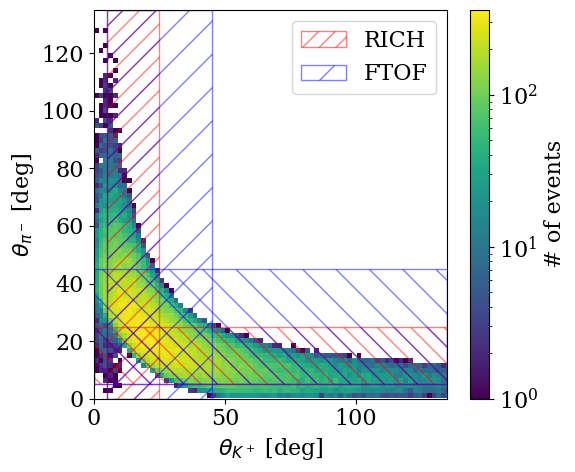

In [12]:
fig,axs= plt.subplots(1,1, figsize=(6, 5))
dfs = df_Kpi, df_KK, df_pipi
lbls_tex = "{K^+} {\\pi^-}".split(), "{K^+} {K^-}".split(), "{\\pi^{+}} {\\pi^{-}}".split()
products="K pi".split(), "K1 K2".split(), "pi1 pi2".split()
for i in range(1):
    #plt.sca(axs[i])
    z,x,y, a = plt.hist2d(dfs[i][f"{products[i][0]}_theta"]*180/np.pi, dfs[i][f"{products[i][1]}_theta"]*180/np.pi, bins =100, norm=matplotlib.colors.LogNorm())
    plt.xlabel(f"$\\theta_{lbls_tex[i][0]}$ [deg]")
    plt.ylabel(f"$\\theta_{lbls_tex[i][1]}$ [deg]")
    plt.axvspan(5, 25, alpha=0.5, edgecolor='red', label='RICH', hatch='//', facecolor='none')
    plt.axhspan(5, 25, alpha=0.5, edgecolor='red', hatch='\\\\', facecolor='none')
    plt.axvspan(5, 45, alpha=0.5, edgecolor='blue', label='FTOF', hatch='/', facecolor='none')
    plt.axhspan(5, 45, alpha=0.5, edgecolor='blue', hatch='\\', facecolor='none')
    #r= patches.Rectangle((5,5), 25-5, 25-5, edgecolor="r", facecolor="none", label='RICH')
    #plt.gca().add_patch(r)
    #r= patches.Rectangle((5,5), 45-5, 45-5, edgecolor="b", facecolor="none", label='FTOF')
    #plt.gca().add_patch(r)
    if i==0:
        cb = plt.colorbar(a)
        cb.set_label("# of events")
        axs.legend()
    plt.xlim(0, 135)
    plt.ylim(0, 135)
    #plt.title(f"$\\bar D_0\\rightarrow {lbls_tex[i][0]}{lbls_tex[i][1]}$")
plt.tight_layout()
plt.savefig("images/D0_decay_theta.png")
plt.show()

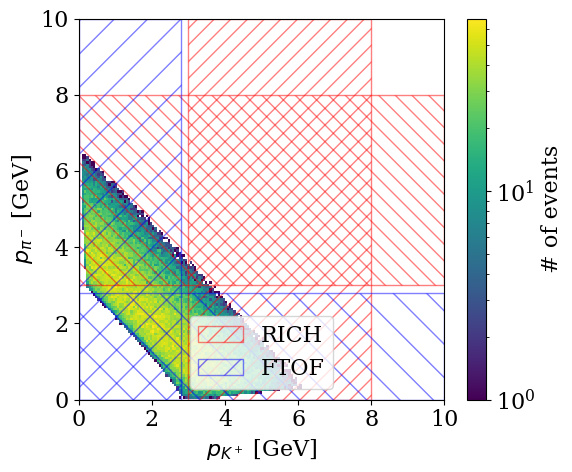

In [13]:
fig,axs= plt.subplots(1,1, figsize=(6, 5))
dfs = df_Kpi, df_KK, df_pipi
lbls_tex = "{K^+} {\\pi^-}".split(), "{K^+} {K^-}".split(), "{\\pi^{+}} {\\pi^{-}}".split()
products="K pi".split(), "K1 K2".split(), "pi1 pi2".split()
for i in range(1):
    #plt.sca(axs[i])
    z,x,y, a = plt.hist2d(dfs[i][f"{products[i][0]}_p"], dfs[i][f"{products[i][1]}_p"], bins =100, norm=matplotlib.colors.LogNorm())
    plt.xlabel(f"$p_{lbls_tex[i][0]}$ [GeV]")
    plt.ylabel(f"$p_{lbls_tex[i][1]}$ [GeV]")
    #r= patches.Rectangle((5,5), 40-5, 40-5, edgecolor="r", facecolor="none")
    #plt.gca().add_patch(r)
    
    plt.axvspan(3, 8, alpha=0.5, edgecolor='red', label='RICH', hatch='//', facecolor='none')
    plt.axhspan(3, 8, alpha=0.5, edgecolor='red', hatch='\\\\', facecolor='none')
    plt.axvspan(0, 2.8, alpha=0.5, edgecolor='blue', label='FTOF', hatch='/', facecolor='none')
    plt.axhspan(0, 2.8, alpha=0.5, edgecolor='blue', hatch='\\', facecolor='none')
    #r= patches.Rectangle((3,3), 8-3, 8-3, edgecolor="r", facecolor="none", label='RICH')
    #plt.gca().add_patch(r)
    #r= patches.Rectangle((0,0), 2.8-0, 2.8-0, edgecolor="b", facecolor="none", label='FTOF')
    #plt.gca().add_patch(r)
    
    if i==0:
        cb = plt.colorbar(a)
        cb.set_label("# of events")
        plt.legend()
    plt.xlim(0, 10)
    plt.ylim(0, 10)
    #plt.title(f"$\\bar D_0\\rightarrow {lbls_tex[i][0]}{lbls_tex[i][1]}$")
plt.tight_layout()
plt.savefig("images/D0_decay_p.png")
plt.show()

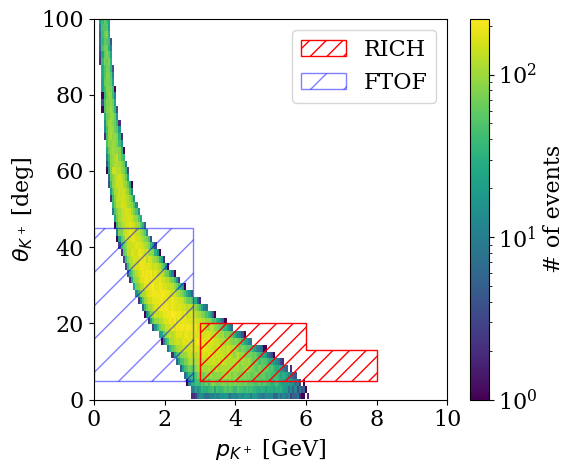

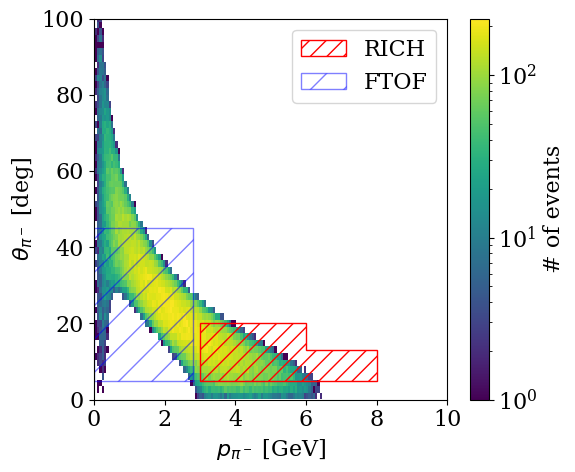

In [14]:
for j in range(2):
    fig,axs= plt.subplots(1,1, figsize=(6, 5))
    dfs = df_Kpi, df_KK, df_pipi
    lbls_tex = "{K^+} {\\pi^-}".split(), "{K^+} {K^-}".split(), "{\\pi^{+}} {\\pi^{-}}".split()
    products="K pi".split(), "K1 K2".split(), "pi1 pi2".split()
    for i in range(1):
        #plt.sca(axs[i])
        z,x,y, a = plt.hist2d(dfs[i][f"{products[i][j]}_p"], dfs[i][f"{products[i][j]}_theta"]*180/np.pi, bins =100, norm=matplotlib.colors.LogNorm())
        plt.xlabel(f"$p_{lbls_tex[i][j]}$ [GeV]")
        plt.ylabel(f"$\\theta_{lbls_tex[i][j]}$ [deg]")
        #r= patches.Rectangle((5,5), 40-5, 40-5, edgecolor="r", facecolor="none")
        #plt.gca().add_patch(r)
        
        x = [3, 8,   8, 3,3]
        y = [5, 5, 40, 40, 5]
        p = patches.Polygon([(3,5),(8,5), (8,13), (6,13),(6,20), (3, 20)], edgecolor='red', label='RICH', hatch='//', facecolor='none')
        plt.gca().add_patch(p)
        
        r= patches.Rectangle((0,5), 2.8-0, 45-5, alpha=0.5, edgecolor='blue', label='FTOF', hatch='/', facecolor='none')
        plt.gca().add_patch(r)
        #plt.axvspan(3, 8, alpha=0.5, edgecolor='red', label='RICH', hatch='//', facecolor='none')
        #plt.axhspan(3, 8, alpha=0.5, edgecolor='red', hatch='\\\\', facecolor='none')
        #plt.axvspan(0, 2.8, alpha=0.5, edgecolor='blue', label='FTOF', hatch='/', facecolor='none')
        #plt.axhspan(0, 2.8, alpha=0.5, edgecolor='blue', hatch='\\', facecolor='none')
        #r= patches.Rectangle((3,3), 8-3, 8-3, edgecolor="r", facecolor="none", label='RICH')
        #plt.gca().add_patch(r)
        #r= patches.Rectangle((0,0), 2.8-0, 2.8-0, edgecolor="b", facecolor="none", label='FTOF')
        #plt.gca().add_patch(r)

        if i==0:
            cb = plt.colorbar(a)
            cb.set_label("# of events")
            plt.legend()
        plt.xlim(0, 10)
        plt.ylim(0, 100)
        #plt.title(f"$\\bar D_0\\rightarrow {lbls_tex[i][0]}{lbls_tex[i][1]}$")
    plt.tight_layout()
    plt.savefig(f"images/D0_decay_p_vs_theta_{products[i][j]}.png")
    plt.show()

(array([[ 75.,  70.,  83., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [ 83.,  93., 100., ...,   0.,   0.,   0.]]),
 array([-1.79983842e+02, -1.76384042e+02, -1.72784241e+02, -1.69184441e+02,
        -1.65584641e+02, -1.61984840e+02, -1.58385040e+02, -1.54785239e+02,
        -1.51185439e+02, -1.47585638e+02, -1.43985838e+02, -1.40386038e+02,
        -1.36786237e+02, -1.33186437e+02, -1.29586636e+02, -1.25986836e+02,
        -1.22387035e+02, -1.18787235e+02, -1.15187435e+02, -1.11587634e+02,
        -1.07987834e+02, -1.04388033e+02, -1.00788233e+02, -9.71884323e+01,
        -9.35886319e+01, -8.99888314e+01, -8.63890310e+01, -8.27892306e+01,
        -7.91894301e+01, -7.55896297e+01, -7.19898293e+01, -6.83900288e+01,
        -6.47902284e+01, -6.11904280e+01, -5.75906275e+01, -5.39908271e

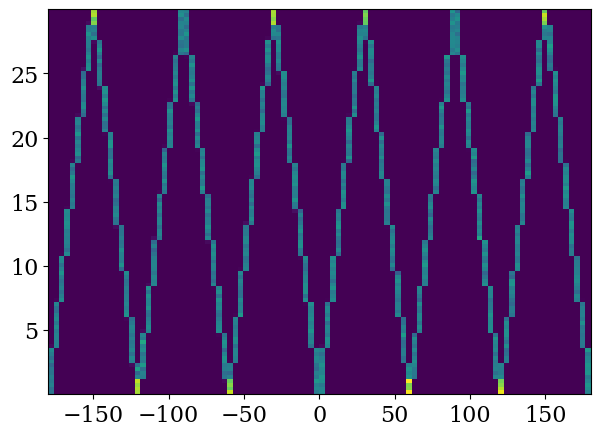

In [105]:
df = df_KK
pname="K1"
phi_in_sector = df[f"{pname}_phi"]-np.pi/6
phi_in_sector = abs(phi_in_sector % (np.pi/3)-np.pi/6)
plt.hist2d(df.K1_phi/(np.pi/180),phi_in_sector/(np.pi/180), bins=100)

# now for $\Lambda_c^+$ decay to $p\pi^+K^-$ (6.28% branching ratio)

In [7]:
Ebeam=10

mp=.9383
mn=.9396
mD0=1.86484
mLambdaC=2.28646
mLambda=1.115683
me=0.000511
mMu=0.1057
mpi_charged = 0.1396
mpi0 = 0.1350
mK_charged = .493677

stot = (Ebeam+mp)**2-Ebeam**2
x1 = mD0**2/stot
x2 = 0.000511**2/stot
x3 = mLambdaC**2/stot

P0=ROOT.TLorentzVector(0, 0, Ebeam,Ebeam+mp)
#ep_to_d0_e_lambdac= oneToThreeGenerator(P0.M(), mD0, me, mLambdaC)
ep_to_d0_e_lambdac= PhotoproductionGenerator(P0.M(), mD0, me, mLambdaC)
LambdaC_decay = oneToThreeGenerator(mLambdaC, mK_charged, mpi_charged, mp)

s13 range: 0.8771726955717146 0.9997694398246769
s13 range: 0.3922336675716795 0.8816175613292485


In [8]:
d1 = {a+"_"+b:[] for a in "D0 e lambdac K pi p".split() for b in "E px py pz p theta phi".split()}
#nucleon type that the lambda decays into (2212 or 2112 for p or n)

for i in range(100000):
    d = {}
    d["D0"],d["e"],d["lambdac"] = ep_to_d0_e_lambdac.next(P0)
    d['p'],d["pi"],d["K"] = LambdaC_decay.next(d["lambdac"])
   
    
    for key in d.keys():
        d1[key + "_E"].append(d[key].E())
        d1[key + "_px"].append(d[key].Px())
        d1[key + "_py"].append(d[key].Py())
        d1[key + "_pz"].append(d[key].Pz())
        d1[key + "_p"].append(d[key].P())
        d1[key + "_theta"].append(d[key].Theta())
        d1[key + "_phi"].append(d[key].Phi())
df_Lambdac = pd.DataFrame(d1)

In [14]:
def RICH_accept(df,pname):
    
    #get the phi relative to the center of the sector
    phi_in_sector = df[f"{pname}_phi"]-np.pi/6
    phi_in_sector = abs(phi_in_sector % (np.pi/3)-np.pi/6)
    
    p = df[f"{pname}_p"]
    theta_d=df[f"{pname}_theta"]*180/np.pi
    selection = (theta_d > 5) & (theta_d<20)
    selection = selection & ((phi_in_sector < np.pi/6*.85)) 
    #assume about 85% azimuthal coverage, since it's not specified
    #this is about 51 degrees per sector
    
    # RICH is only in sectors 1, 4
    selection = selection & ((abs(df[f"{pname}_phi"])>5/6*np.pi) | (abs(df[f"{pname}_phi"])<1/6*np.pi))
    
    # theta-dependent momentum cuts.
    selection = selection & (((theta_d<13) & (p>3) & (p<8)) | ((theta_d>=13) & (p>3) & (p<6)))
    
    return selection

def FTOF_accept(df,pname):
    phi_in_sector = df[f"{pname}_phi"]-np.pi/6
    phi_in_sector = abs(phi_in_sector % (np.pi/3)-np.pi/6)
    theta_d = df[f"{pname}_theta"]*180/np.pi
    p = df[f"{pname}_p"]
    
    selection = (theta_d>5) & (theta_d<45)
    selection = selection & ((phi_in_sector < np.pi/6*(.5+(theta_d-5)/(35-5)*(.85-.5))) | \
                             (phi_in_sector < np.pi/6*(.85+(theta_d-35)/(45-35)*(.90-.85))))
    selection = selection & (p<2.8)             
    return selection

def FCAL_accept(df,pname):
    #what fraction of the events have a muon that enters the acceptance of the fcal?
    #plot the theta distribution of the accepted events and all events.
    z_front = 1300
    detector_length=300
    detector_ymin = -220
    detector_ymax = -8
    uxmax = (detector_length/2)/z_front
    uymin = detector_ymin/z_front
    uymax = detector_ymax/z_front
    ux = df[f"{pname}_px"]/df[f"{pname}_pz"] 
    uy = df[f"{pname}_py"]/df[f"{pname}_pz"] 
    return (abs(ux)<uxmax)& (uy>uymin) & (uy<uymax)

ftot=0
probtot=0
df= df_Lambdac; 
products ="pi K p".split()
#num = len(df.query(RICH_accept(products[0]) + " and " + RICH_accept(products[1])))
num = len(df[(FTOF_accept(df, products[0]) | RICH_accept(df, products[0])) & 
             (FTOF_accept(df, products[1]) | RICH_accept(df, products[1])) &
            (FTOF_accept(df, products[2]) | RICH_accept(df, products[2]) | FCAL_accept(df, products[2]) )] 
         )
denom = len(df)
prob = num/denom
print(products,num, denom, prob)


['pi', 'K', 'p'] 22388 100000 0.22388


In [156]:
eff_FTOF = .98
eff_RICH = .90

eff = 1
for i in range(3):
    facc = FTOF_accept(df, products[i])
    racc = RICH_accept(df, products[i])
    eff = eff*(eff_FTOF*facc + eff_RICH*racc-eff_FTOF*eff_RICH*facc*racc)
num = sum(eff)
#                   FTOF_accept(df, products[0])*RICH_accept(df, products[0])*eff_FTOF
#num = sum((FTOF_accept(df, products[0])*eff_FTOF + RICH_accept(df, products[0])*eff_RICH) * 
#             (FTOF_accept(df, products[1])*eff_FTOF + RICH_accept(df, products[1])*eff_RICH) *
#            (FTOF_accept(df, products[2])*eff_FTOF + RICH_accept(df, products[2])*eff_RICH))
denom = len(df[(FTOF_accept(df, products[0]) | RICH_accept(df, products[0])) & 
             (FTOF_accept(df, products[1]) | RICH_accept(df, products[1])) &
            (FTOF_accept(df, products[2]) | RICH_accept(df, products[2]))] 
         )
print(num/denom)

0.9260198453612337
